<a href="https://colab.research.google.com/github/AdityaPunetha/ML-Projects/blob/main/TensorFlow-Fashion-MNIST-Conditional-GAN/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [1]:
from numpy import expand_dims, ones, zeros, squeeze, asarray
from numpy.random import randn, randint
from matplotlib import pyplot as plt
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.saved_model import save
from tensorflow.keras.layers import (
    Input,
    Dense,
    Reshape,
    Flatten,
    Conv2D,
    Conv2DTranspose,
    LeakyReLU,
    ReLU,
    Dropout,
    Embedding,
    Concatenate,
)


%matplotlib inline

# Load Data

In [2]:
(trainX, trainy), (_, _) = load_data()
print('Train', trainX.shape, trainy.shape)

Train (60000, 28, 28) (60000,)


# Define Discriminator

In [3]:
in_shape=(28,28,1)
n_classes=10

In [4]:
def define_discriminator():
	in_label = Input(shape=(1,))
	li = Embedding(n_classes, 50)(in_label)
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	li = Reshape(in_shape)(li)
	in_image = Input(shape=in_shape)

	merge = Concatenate()([in_image, li])

	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	fe = Flatten()(fe)
	fe = Dropout(0.4)(fe)

	out_layer = Dense(1, activation='sigmoid')(fe)

	model = Model([in_image, in_label], out_layer)

	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [5]:
discriminator = define_discriminator()

In [6]:
discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 784)       39984       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                              

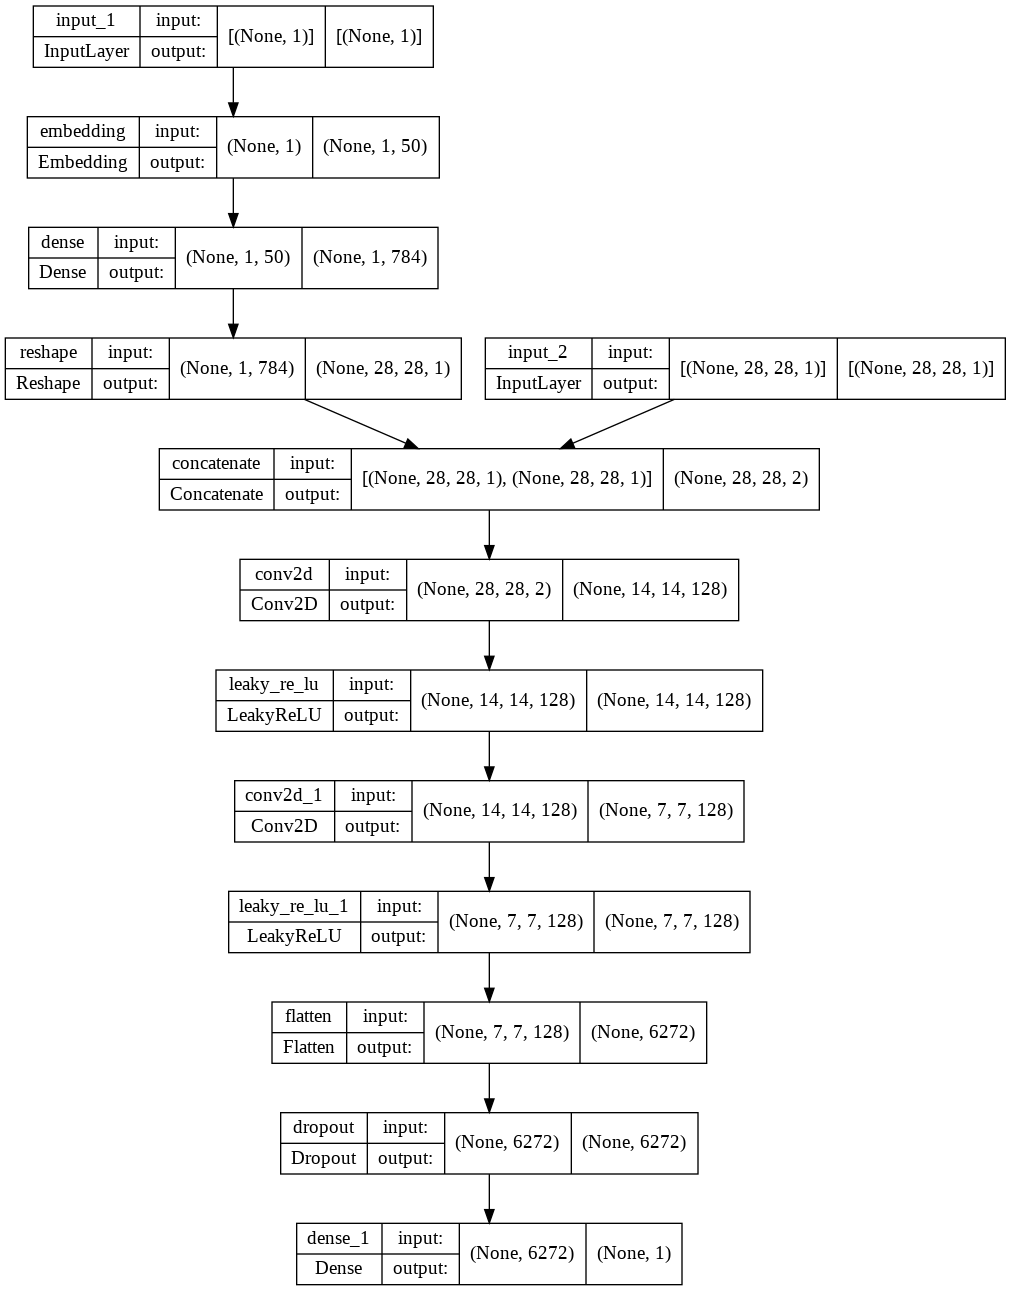

In [7]:
plot_model(discriminator, show_shapes=True)

# Define Generator

In [8]:
latent_size = 100

In [9]:
def define_generator(n_classes=10):
	in_label = Input(shape=(1,))
	li = Embedding(n_classes, 50)(in_label)
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	li = Reshape((7, 7, 1))(li)
 
	in_lat = Input(shape=(latent_size,))

	n_nodes = 128 * 7 * 7

	gen = Dense(n_nodes)(in_lat)
	gen = ReLU()(gen)
	gen = Reshape((7, 7, 128))(gen)

	merge = Concatenate()([gen, li])

	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = ReLU()(gen)

	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = ReLU()(gen)

	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)

	model = Model([in_lat, in_label], out_layer)
	return model

In [10]:
generator = define_generator()

In [11]:
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 6272)         633472      ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                            

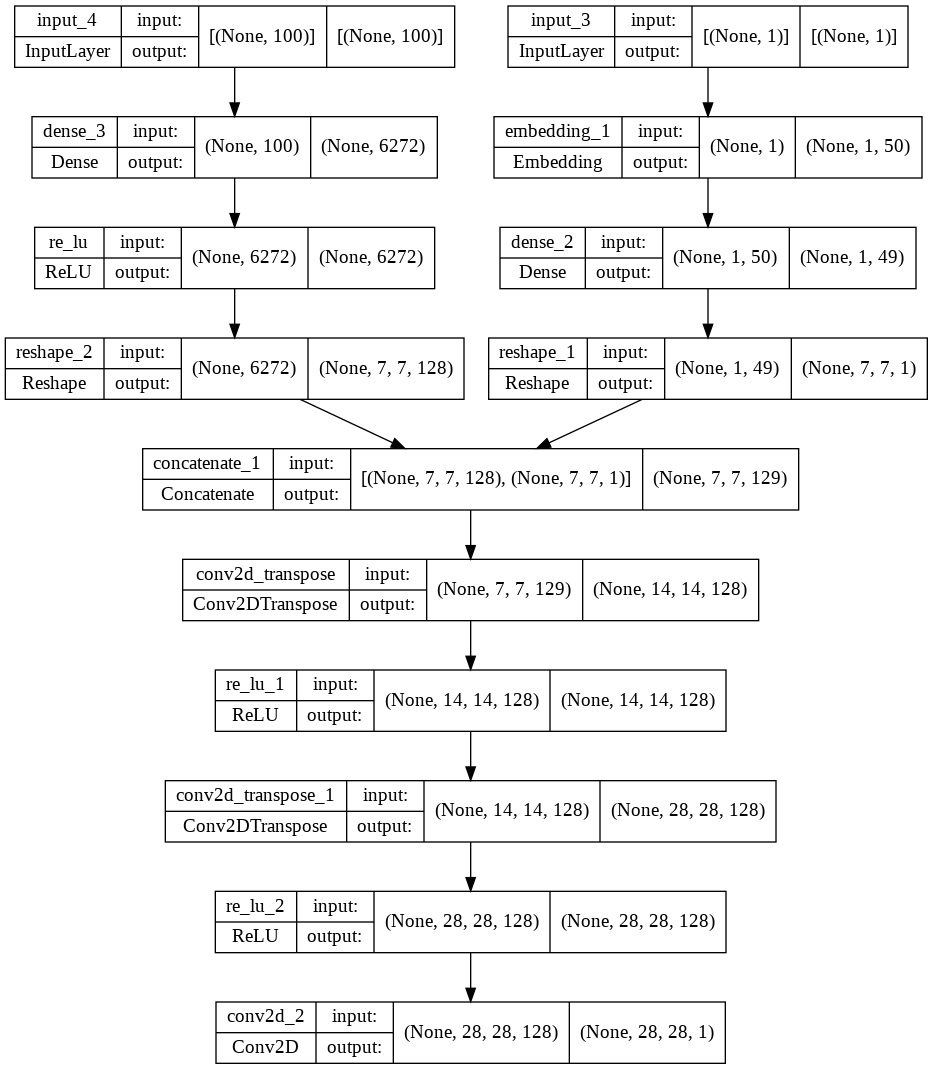

In [12]:
plot_model(generator, show_shapes=True)

In [52]:
sample_generated_image = generator.predict([randn(1,latent_size),randint(0, 10, 1)])

In [ ]:
plt.imshow(squeeze(sample_generated_image), cmap = 'gray_r')

# Define Generator

In [15]:
def define_gan(g_model, d_model):
	d_model.trainable = False
	gen_noise, gen_label = g_model.input

	gen_output = g_model.output
	gan_output = d_model([gen_output, gen_label])

	model = Model([gen_noise, gen_label], gan_output)

	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [16]:
gan_model = define_gan(generator, discriminator)

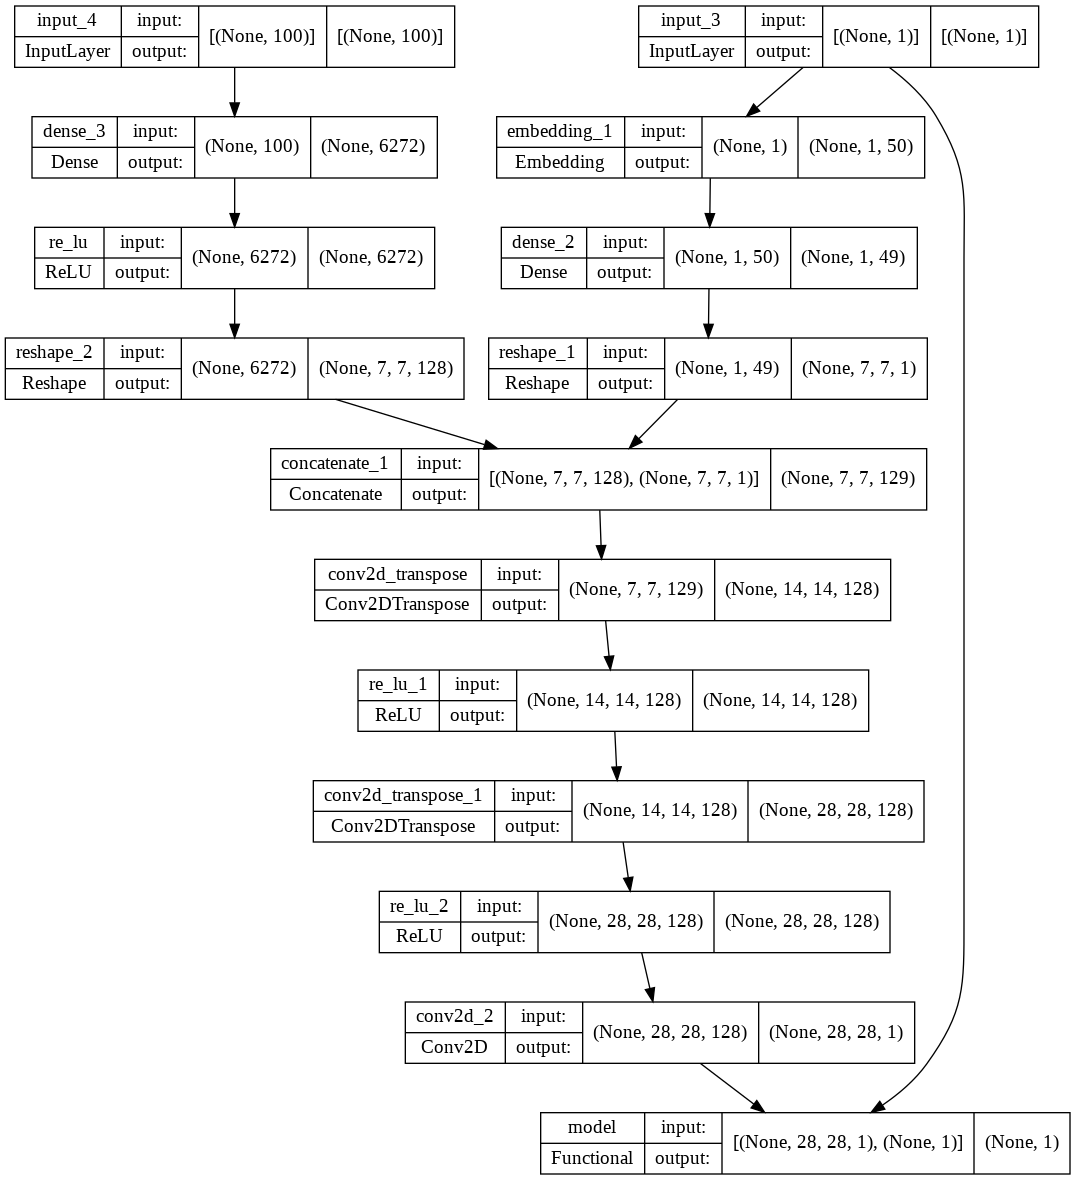

In [17]:
plot_model(gan_model, show_shapes=True)

# Train Dicriminator

In [18]:
batch_size = 600

In [19]:
X = expand_dims(trainX, axis=-1)
X = X.astype('float32')
X = (X - 127.5) / 127.5

In [20]:
def generate_real_samples(dataset, n_samples):
	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	return [X, labels]

In [21]:
def train_discriminator(real_samples):
  real_labels = ones((batch_size,1))
  fake_labels = zeros((batch_size,1))

  d_loss_real, _ = discriminator.train_on_batch(real_samples,real_labels)

  labels = randint(0, 10, batch_size)

  generated_images = generator([randn(batch_size,latent_size), labels])

  d_loss_fake, _ = discriminator.train_on_batch([generated_images, labels], fake_labels)

  d_loss = d_loss_fake + d_loss_real

  return d_loss, d_loss_fake, d_loss_real

# Training the model

In [22]:
bat_per_epo = int(X.shape[0] / batch_size)

In [23]:
bat_per_epo

100

In [24]:
num_epochs = 100
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i in range(bat_per_epo):
      X_real = generate_real_samples([X, trainy], batch_size)

      d_loss, d_loss_fake, d_loss_real = train_discriminator(X_real)

      g_loss = gan_model.train_on_batch([randn(batch_size,latent_size), randint(0, 10, batch_size)], ones((batch_size, 1)))

      if (i+1) % 100 == 0:
          d_losses.append(d_loss)
          g_losses.append(g_loss)

          print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'.format(epoch, num_epochs, i+1, bat_per_epo, d_loss, g_loss))

Epoch [0/100], Step [100/100], d_loss: 1.5644, g_loss: 0.6470
Epoch [1/100], Step [100/100], d_loss: 0.8668, g_loss: 1.6087
Epoch [2/100], Step [100/100], d_loss: 1.2635, g_loss: 1.2163
Epoch [3/100], Step [100/100], d_loss: 1.5471, g_loss: 0.6318
Epoch [4/100], Step [100/100], d_loss: 1.2607, g_loss: 0.7956
Epoch [5/100], Step [100/100], d_loss: 1.2140, g_loss: 0.8266
Epoch [6/100], Step [100/100], d_loss: 1.1135, g_loss: 0.9915
Epoch [7/100], Step [100/100], d_loss: 1.2912, g_loss: 0.8626
Epoch [8/100], Step [100/100], d_loss: 1.4089, g_loss: 0.7175
Epoch [9/100], Step [100/100], d_loss: 1.3510, g_loss: 0.8230
Epoch [10/100], Step [100/100], d_loss: 1.3194, g_loss: 0.8175
Epoch [11/100], Step [100/100], d_loss: 1.2999, g_loss: 0.7808
Epoch [12/100], Step [100/100], d_loss: 1.3249, g_loss: 0.7824
Epoch [13/100], Step [100/100], d_loss: 1.3391, g_loss: 0.7885
Epoch [14/100], Step [100/100], d_loss: 1.2650, g_loss: 0.8061
Epoch [15/100], Step [100/100], d_loss: 1.3142, g_loss: 0.7809
Ep

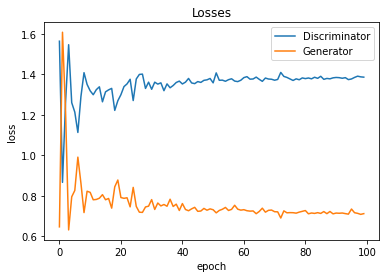

In [25]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [72]:
def show_plot(examples, n):
	for i in range(n * n):
		plt.subplot(n, n, 1 + i)
		plt.axis('off')
		plt.imshow(squeeze(examples[i, :, :, :]),cmap = 'gray')
	plt.show()

In [59]:
trained_generator_sample_images = generator.predict([randn(100,latent_size), asarray([j for _ in range(10) for j in range(10)])])

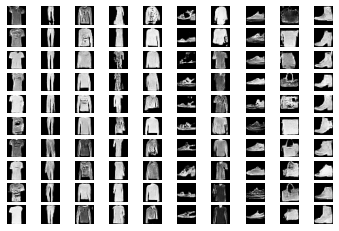

In [73]:
show_plot(trained_generator_sample_images, 10)

# Save Model

In [47]:
save(generator,"generator")

INFO:tensorflow:Assets written to: generator/assets


In [49]:
!zip -r /content/generator.zip /content/generator


  adding: content/generator/ (stored 0%)
  adding: content/generator/variables/ (stored 0%)
  adding: content/generator/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/generator/variables/variables.index (deflated 52%)
  adding: content/generator/assets/ (stored 0%)
  adding: content/generator/saved_model.pb (deflated 89%)
